# <center> Proyecto Pilas: CNN Model </center>
<center> TIMMD - Julian Rodriguez y Lucas Argento </center>

## 0) Uploading de las fotos de local a Gdrive para trabajar con GPU en colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FinalDataset2.zip to FinalDataset2.zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['FinalDataset2.zip']), 'r')
data.extractall()

In [ ]:
data.printdir()

File Name                                             Modified             Size
FinalDataset/                                  2022-12-05 18:59:18            0
FinalDataset/.DS_Store                         2022-12-05 18:59:18         6148
__MACOSX/FinalDataset/._.DS_Store              2022-12-05 18:59:18          120
FinalDataset/test/                             2022-12-05 18:59:12            0
FinalDataset/train/                            2022-12-05 18:59:12            0
FinalDataset/val/                              2022-12-05 18:59:18            0
FinalDataset/test/.DS_Store                    2022-12-05 18:59:12         6148
__MACOSX/FinalDataset/test/._.DS_Store         2022-12-05 18:59:12          120
FinalDataset/test/Boton chico/                 2022-12-05 18:37:32            0
FinalDataset/test/Duracell/                    2022-12-05 18:37:32            0
FinalDataset/test/Otras/                       2022-12-05 18:37:32            0
FinalDataset/test/Boton grande/         

In [ ]:
import os

In [ ]:
train_data_dir = 'FinalDataset/train'  
validation_data_dir = 'FinalDataset/val'  
test_data_dir = 'FinalDataset/test' 
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['Otras', 'Boton chico', 'Duracell', 'Energizer', 'Boton grande'] 
 - # of classes:  5
 - # of trained samples:  1961 
 - # of validation samples:  246 
 - # of test samples:  246 
 - total # of samples:  2453 
 - train ratio: 79.94 
 - validation ratio: 10.03 
 - test ratio: 10.03


## 1) Librerias a utilizar

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import time
import random
from itertools import product

> Utils.py file, condensado en una celda

In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat


def train_model(
    model, 
    num_epochs, 
    train_loader, 
    valid_loader, 
    test_loader, 
    optimizer,
    device, 
    log_interval_batch=50
):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            #print("salida prop adelante", logits)
            #print("Targets", targets)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            #if not batch_idx % log_interval_batch:
            print(f'Epoca: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoca: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list




> Plot_utils.py file, condensado en una celda

In [ ]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epocas')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoca')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

## 2) Carga de los datos a Torch

In [ ]:
# Como se menciono antes, nuestro dataset contiene imagenes en 300x300
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Transformamos a tensores para poder procesar las imagenes con PyTorch
transform = transforms.ToTensor()

# Transformaciones y loadding
train_data = datasets.ImageFolder(root='FinalDataset/train',transform=transform)
test_data = datasets.ImageFolder(root='FinalDataset/test',transform=transform)
val_data = datasets.ImageFolder(root='FinalDataset/val',transform=transform)

## 3) Arquitectura de la CNN

Para el estudio de las CNNs, decidimos partir de la arquitectura original de la Red Neuronal **LeNet** (1998), la cual luego modificaremos para estudiar los efectos de las distintas decisiones de diseño. 
A continuacion, se observa un esquema de la arquitectura original, compuesta por dos capas convolucionales y 3 capas FullyConnected de Perceptrones Multicapa. Si bien la red original usaba funciones de activacion de tangenge hiperbólica, en nuestro caso se utilizaron funciones ReLu.
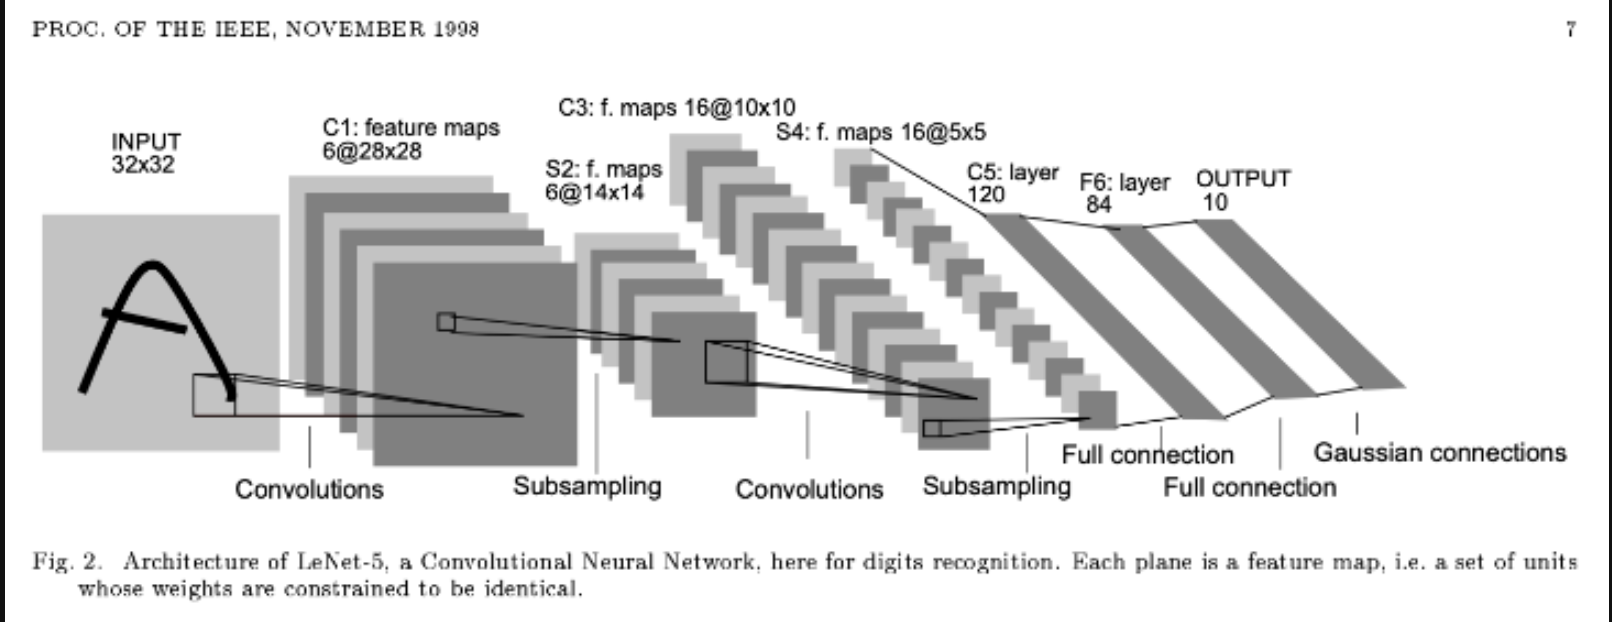

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, image_size, n_canales_rgb, n_clases, cantidad_filtros_conv, tamaño_filtro_conv, 
                 tamaño_kernel_pooling, stride, padding):
        super().__init__()
        # cantidad de canales y clases, a definir por el diseñador
        self.n_canales_rgb = n_canales_rgb
        self.n_clases = n_clases
        self.tamaño_kernel_pooling = tamaño_kernel_pooling
        # Le net tiene dos capas convolucionales
        self.conv1 = nn.Conv2d(self.n_canales_rgb, cantidad_filtros_conv, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv1 = math.floor(((image_size - tamaño_filtro_conv + 2 * padding)/stride) + 1)
        # outputconv1 = math.floor(((128 - tamaño_filtro_conv)/stride))
        # falta un +1 al final ?? tener en cuenta el padding
        # asi seria? outputconv1 = math.floor(((128 - tamaño_filtro_conv + 2* padding)/stride) + 1)
        
        print("imagenes de salida post convolucion1:", outputconv1, "x", outputconv1)
        outputconv1 = math.floor(((outputconv1 - tamaño_kernel_pooling)/ stride ) + 1)
        print("imagenes de salida post pooling1:", outputconv1, "x", outputconv1)
        
        self.conv2 = nn.Conv2d(cantidad_filtros_conv, cantidad_filtros_conv*4, kernel_size=tamaño_filtro_conv, stride=stride, padding=padding)
        
        outputconv2 = math.floor((((outputconv1 - tamaño_filtro_conv)+ 2 * padding)/stride) + 1)
        print("imagenes de salida post convolucion2:", outputconv2, "x", outputconv2)
        outputconv2 = math.floor(((outputconv2 - tamaño_kernel_pooling)/ stride ) + 1)
        print("imagenes de salida post pooling2:", outputconv2, "x", outputconv2)

        # size del vector de parametros luego de las capas convolucionales
        cantidad_parametros = math.floor(cantidad_filtros_conv *4 * outputconv2 * outputconv2)
        print("cantidad de parametros en unrolling:",cantidad_parametros)
        # y tres capas de MLPs
        
        # primer MLP
        inputfc1 = math.floor(cantidad_parametros)
        print("parametros de entrada del primer perceptron:", inputfc1)
        outputfc1 = math.floor((1/2)*inputfc1)
        print("parametros de salida del primer perceptron:", outputfc1)
        
        self.fc1 = torch.nn.Linear(inputfc1, outputfc1)
        # segundo MLP
        inputfc2 = outputfc1
        print("parametros de entrada del segundo perceptron:", inputfc2)
        outputfc2 = math.floor(inputfc2*(1/2))
        print("parametros de salida del segundo perceptron:", outputfc2)
        self.fc2 = torch.nn.Linear(inputfc2, outputfc2)
        # tercer MLP. salida con cantidad de clases
        inputfc3 = outputfc2
        print("parametros de entrada del tercer perceptron:", inputfc3)
        self.fc3 = torch.nn.Linear(inputfc3, self.n_clases)

    def forward(self, x):
        # capa convolucional
        x = self.conv1(x)
        # al resultado de la convolucion, le aplica una ReLu
        x = F.relu(x)
        # y luego un pooling
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # Segunda capa convolucional
        x = self.conv2(x)
        # aplica relu
        x = F.relu(x)
        # pooling 
        x = F.max_pool2d(x, (self.tamaño_kernel_pooling, self.tamaño_kernel_pooling))
        
        # flatten de las imagenes para pasarlo a MLPs
        x = torch.flatten(x, 1)
        # MLPs con relus
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

> Para no tener que repetir tareas de codigo en caso de que variemos los hiperparametros de la red, vamos a modularizar el creado y entrenamiento del modelo

In [ ]:
def crear_modelo(image_size, canales_color, cant_clases, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):
    # Instanciamos la clase del modelo:
    model = LeNet5(image_size, canales_color, cant_clases, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding)
    # CUDA / CPU
    model = model.to('cuda')
    return model

In [ ]:
def entrenar_modelo(model, optimizer, epocas, batch_size, train_data, val_data, test_data):
    # Cargamos data en PyTorch
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle = True,                                        
                                               num_workers=0)

    valid_loader = torch.utils.data.DataLoader(val_data,
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=0)

    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle = True,
                                              num_workers=0)
    
    # Entrenamiento del modelo
    minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
        model=model,
        num_epochs= NUM_EPOCAS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        test_loader=test_loader,
        optimizer=optimizer,
        device='cuda',
        log_interval_batch=1)
    # Devuelvo listas para controlar el desempeño del entrenamiento
    return minibatch_loss_list, train_acc_list, valid_acc_list, train_loader

In [ ]:
torch.manual_seed(0)

## 4) Primer modelo y entrenamiento

In [ ]:
#los params de la funcion son: image_size, canales_color, cant_clases, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):

model_1 = crear_modelo(128, 3, 5, 16, 5, 2, 2, 0)

imagenes de salida post convolucion1: 62 x 62
imagenes de salida post pooling1: 31 x 31
imagenes de salida post convolucion2: 14 x 14
imagenes de salida post pooling2: 7 x 7
cantidad de parametros en unrolling: 3136
parametros de entrada del primer perceptron: 3136
parametros de salida del primer perceptron: 1568
parametros de entrada del segundo perceptron: 1568
parametros de salida del segundo perceptron: 784
parametros de entrada del tercer perceptron: 784


In [ ]:
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
NUM_EPOCAS = 10
valid_size = 0.2
batch_size = 128

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_1, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

Epoca: 001/010 | Batch 0000/0016 | Loss: 1.6042
Epoca: 001/010 | Batch 0001/0016 | Loss: 1.5067
Epoca: 001/010 | Batch 0002/0016 | Loss: 1.3018
Epoca: 001/010 | Batch 0003/0016 | Loss: 1.7429
Epoca: 001/010 | Batch 0004/0016 | Loss: 1.5430
Epoca: 001/010 | Batch 0005/0016 | Loss: 1.4485
Epoca: 001/010 | Batch 0006/0016 | Loss: 1.4213
Epoca: 001/010 | Batch 0007/0016 | Loss: 1.4725
Epoca: 001/010 | Batch 0008/0016 | Loss: 1.4972
Epoca: 001/010 | Batch 0009/0016 | Loss: 1.5002
Epoca: 001/010 | Batch 0010/0016 | Loss: 1.4865
Epoca: 001/010 | Batch 0011/0016 | Loss: 1.4726
Epoca: 001/010 | Batch 0012/0016 | Loss: 1.4798
Epoca: 001/010 | Batch 0013/0016 | Loss: 1.4131
Epoca: 001/010 | Batch 0014/0016 | Loss: 1.3837
Epoca: 001/010 | Batch 0015/0016 | Loss: 1.3348
Epoca: 001/010 | Train: 34.69% | Validation: 35.10%
Epoca: 002/010 | Batch 0000/0016 | Loss: 1.4186
Epoca: 002/010 | Batch 0001/0016 | Loss: 1.4457
Epoca: 002/010 | Batch 0002/0016 | Loss: 1.2757
Epoca: 002/010 | Batch 0003/0016 | L

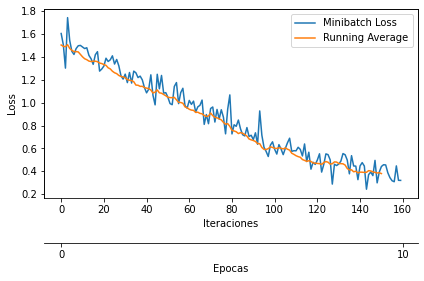

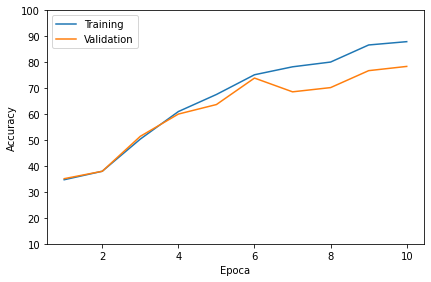

In [ ]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 10)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> El primer modelo que probamos, con un Lr = 0.001, 128 batch size, 10 epocas y una arquitectura CNN de:
- cantidad_filtros_conv = 16
- tamaño_filtro_conv= 5x5
- tamaño_kernel_pooling = 2x2
- stride = 2
- padding = 0

Logró una Accuracy del 83 %. Vamos a ver si podemos mejorar eso con una mayor cantidad de epocas y variando los HP de la arquitectura.

## 5) Segundo modelo y entrenamiento

In [74]:
#los params de la funcion son: image_size, canales_color, cant_clases, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):

model_2 = crear_modelo(128, 3, 5, 16, 5, 2, 2, 0)

imagenes de salida post convolucion1: 62 x 62
imagenes de salida post pooling1: 31 x 31
imagenes de salida post convolucion2: 14 x 14
imagenes de salida post pooling2: 7 x 7
cantidad de parametros en unrolling: 3136
parametros de entrada del primer perceptron: 3136
parametros de salida del primer perceptron: 1568
parametros de entrada del segundo perceptron: 1568
parametros de salida del segundo perceptron: 784
parametros de entrada del tercer perceptron: 784


In [75]:
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

> Modificamos la cantidad de epocas a 50, ceteris paribus

In [76]:
NUM_EPOCAS = 50
valid_size = 0.2
batch_size = 128

In [77]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_2, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

Epoca: 001/050 | Batch 0000/0016 | Loss: 1.6033
Epoca: 001/050 | Batch 0001/0016 | Loss: 1.4302
Epoca: 001/050 | Batch 0002/0016 | Loss: 1.3849
Epoca: 001/050 | Batch 0003/0016 | Loss: 1.5194
Epoca: 001/050 | Batch 0004/0016 | Loss: 1.3387
Epoca: 001/050 | Batch 0005/0016 | Loss: 1.4251
Epoca: 001/050 | Batch 0006/0016 | Loss: 1.4493
Epoca: 001/050 | Batch 0007/0016 | Loss: 1.3847
Epoca: 001/050 | Batch 0008/0016 | Loss: 1.4513
Epoca: 001/050 | Batch 0009/0016 | Loss: 1.4167
Epoca: 001/050 | Batch 0010/0016 | Loss: 1.3753
Epoca: 001/050 | Batch 0011/0016 | Loss: 1.2441
Epoca: 001/050 | Batch 0012/0016 | Loss: 1.3306
Epoca: 001/050 | Batch 0013/0016 | Loss: 1.3062
Epoca: 001/050 | Batch 0014/0016 | Loss: 1.3381
Epoca: 001/050 | Batch 0015/0016 | Loss: 1.2205
Epoca: 001/050 | Train: 38.16% | Validation: 39.59%
Epoca: 002/050 | Batch 0000/0016 | Loss: 1.2431
Epoca: 002/050 | Batch 0001/0016 | Loss: 1.3390
Epoca: 002/050 | Batch 0002/0016 | Loss: 1.3303
Epoca: 002/050 | Batch 0003/0016 | L

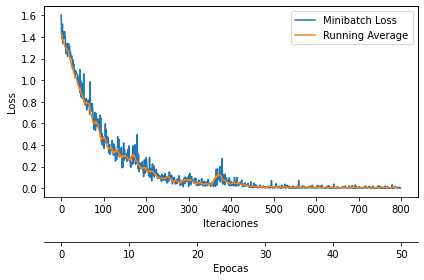

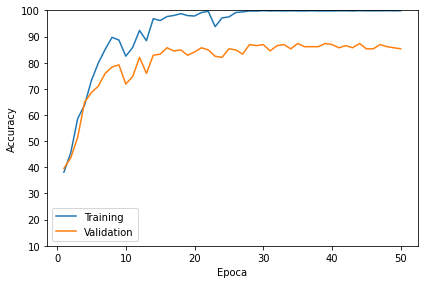

In [78]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 10)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> El segundo modelo que probamos, con un Lr = 0.001, 128 batch size, **50** **epocas** y una arquitectura CNN de:
- cantidad_filtros_conv = 16
- tamaño_filtro_conv= 5x5
- tamaño_kernel_pooling = 2x2
- stride = 2
- padding = 0

Logró una Accuracy mucho mejor, del 90.61 %. Vamos a ver si podemos mejorar eso variando los HP de la arquitectura.

## 6) Tercer modelo y entrenamiento

> Duplicamos la cantidad de filtros convolucionales de la primera capa (de 16 a 32) lo que implica un aumento de features convolucionales y una mayor cantidad de neuronas en los MLPs. Vamos a ver si esto enriquece a nuestra red

In [ ]:
#los params de la funcion son: image_size, canales_color, cant_clases, cantidad_filtros_conv, tamaño_filtro_conv, tamaño_kernel_pooling, stride, padding):

model_3 = crear_modelo(128, 3, 5, 32, 5, 2, 2, 0)

imagenes de salida post convolucion1: 62 x 62
imagenes de salida post pooling1: 31 x 31
imagenes de salida post convolucion2: 14 x 14
imagenes de salida post pooling2: 7 x 7
cantidad de parametros en unrolling: 6272
parametros de entrada del primer perceptron: 6272
parametros de salida del primer perceptron: 3136
parametros de entrada del segundo perceptron: 3136
parametros de salida del segundo perceptron: 1568
parametros de entrada del tercer perceptron: 1568


In [ ]:
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [ ]:
NUM_EPOCAS = 50
valid_size = 0.2
batch_size = 128

In [ ]:
minibatch_loss_list, train_acc_list, valid_acc_list, train_loader = entrenar_modelo(model_3, 
                                                                      optimizer, 
                                                                      NUM_EPOCAS, 
                                                                      batch_size, 
                                                                      train_data, 
                                                                      val_data, 
                                                                      test_data)

Epoca: 001/050 | Batch 0000/0016 | Loss: 1.6042
Epoca: 001/050 | Batch 0001/0016 | Loss: 1.3737
Epoca: 001/050 | Batch 0002/0016 | Loss: 1.4270
Epoca: 001/050 | Batch 0003/0016 | Loss: 1.4640
Epoca: 001/050 | Batch 0004/0016 | Loss: 1.3265
Epoca: 001/050 | Batch 0005/0016 | Loss: 1.3647
Epoca: 001/050 | Batch 0006/0016 | Loss: 1.2406
Epoca: 001/050 | Batch 0007/0016 | Loss: 1.1389
Epoca: 001/050 | Batch 0008/0016 | Loss: 1.2633
Epoca: 001/050 | Batch 0009/0016 | Loss: 1.2242
Epoca: 001/050 | Batch 0010/0016 | Loss: 1.2388
Epoca: 001/050 | Batch 0011/0016 | Loss: 1.2400
Epoca: 001/050 | Batch 0012/0016 | Loss: 1.1281
Epoca: 001/050 | Batch 0013/0016 | Loss: 1.1110
Epoca: 001/050 | Batch 0014/0016 | Loss: 1.2333
Epoca: 001/050 | Batch 0015/0016 | Loss: 1.0588
Epoca: 001/050 | Train: 45.15% | Validation: 45.71%
Epoca: 002/050 | Batch 0000/0016 | Loss: 1.0432
Epoca: 002/050 | Batch 0001/0016 | Loss: 1.0915
Epoca: 002/050 | Batch 0002/0016 | Loss: 1.1261
Epoca: 002/050 | Batch 0003/0016 | L

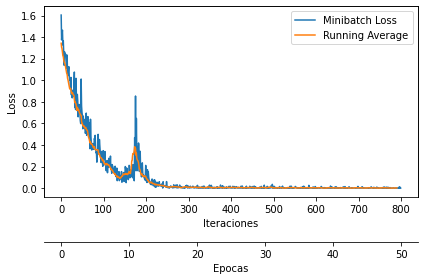

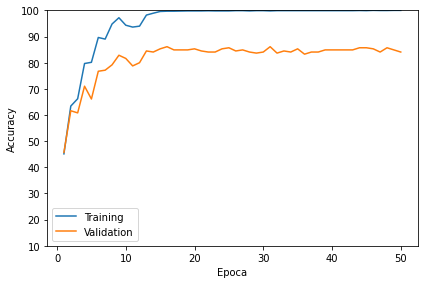

In [ ]:
# Plot function de utils
plot_training_loss(minibatch_loss_list = minibatch_loss_list,
                   num_epochs = NUM_EPOCAS,
                   iter_per_epoch = len(train_loader),
                   averaging_iterations = 10)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list)
plt.ylim([10, 100])
plt.show()

> El segundo modelo que probamos, con un Lr = 0.001, 128 batch size, **50** **epocas** y una arquitectura CNN de:
- cantidad_filtros_conv = 32
- tamaño_filtro_conv= 5x5
- tamaño_kernel_pooling = 2x2
- stride = 2
- padding = 0

Logró una Accuracy peor, del 89.80 %.

Se ve que al rededor de las 30 epocas el modelo logro su mejor score en el test de validacion, por lo que bajar el numero de epocas podria evitar algo de overfitting y mejorar la performance en los samples no vistos del test set. 

Sin embargo, vamos a utilizar el segundo modelo que logro una mejor performance.

## 7) Realizando predicciones con el mejor modelo

In [79]:
model_2

LeNet5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=5, bias=True)
)

In [80]:
# Specify a path
PATH = "best_model.pt"
# Save
torch.save(model_2, PATH)

In [81]:
# Load
model_predict = torch.load(PATH)
model_predict.eval()

LeNet5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=5, bias=True)
)

In [82]:
model_predict.to("cuda")

LeNet5(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1568, bias=True)
  (fc2): Linear(in_features=1568, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=5, bias=True)
)

Boton chico  at confidence score: 1.00



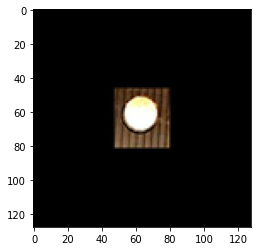

In [102]:
from PIL import Image

class_names = ['Boton chico', 'Boton grande', 'Duracell', 'Energizer', 'Otras']

def get_prediction(tensor, device):
    tensor = tensor.to(device)
    output = model_predict.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), class_names[classes.item()]

# muestro la imagen
image_path="/content/FinalDataset/test/Boton chico/075.jpg_contrast.jpg"
image = plt.imread(image_path)
plt.imshow(image)

# imagen a tensor y predecir, imprimir prediccion
img = Image.open(image_path)

convert_tensor = transforms.ToTensor()
tensor = convert_tensor(img)
tensor = tensor.unsqueeze(0)
tensor = tensor.to("cuda")

conf, y_pre = get_prediction(tensor= tensor, device = "cuda")
print(y_pre, ' at confidence score: {0:.2f}\n'.format(conf))
